In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lin
import scipy.sparse as sparse
import scipy.sparse.linalg as slin
import itertools
import sklearn
import time
from IPython.display import display_markdown, Markdown
%matplotlib inline

# read data

In [6]:
def is_mitochrondial(df):
    return df.a.str.match(r'Q.*') | df.b.str.match(r'Q.*') | df.a.str.match(r't.*') | df.b.str.match(r't.*')
def detect_mitochrondrial(df):
    return np.any(is_mitochrondial(df))
def remove_mitochrondrial(df):
    return df[~is_mitochrondial(df)]

def dict_to_np(d): #ensures proper ordering, if for whatever reason the keys are out of numerical order
    return np.array([d[i] for i in range(len(d))])

## read protein-protein interaction data

Data from [Reguly et al 2006](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1561585/)

Read header

In [3]:
pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', nrows = 1)

,Bait gene/protein,Hit gene/protein,Bait Standard Name,Hit Standard Name,Experimental System,Source,PubMed ID
0,YBR236C,YML010W,ABD1,SPT5,Affinity Capture-MS,Lindstrom DL et al,12556496


Load data

In [7]:
usecols = 'Bait gene/protein,Hit gene/protein'.split(',')
colnames = 'a,b'.split(',')
reguly = pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', usecols = usecols,
                     dtype="str")
reguly = reguly.rename(columns={k : v for k,v in zip(usecols,colnames)})

reguly = remove_mitochrondrial(reguly) #remove mitochrondrial proteins

display(reguly)
print(np.count_nonzero(reguly.duplicated()), 'duplicates')
print(len(reguly) - np.count_nonzero(reguly.duplicated()), 'unique')

,a,b
0,YBR236C,YML010W
1,YML010W,YBR236C
2,YDR448W,YPL254W
3,YDR448W,YDR176W
4,YDR448W,YOR257W
...,...,...
21130,YKL138C-A,YDR201W
21131,YKL138C-A,YKR083C
21132,YKL138C-A,YDR016C
21133,YKL138C-A,YBR233W-A


6956 duplicates
14135 unique


Sort each row and delete duplicates, since we are only interested in undirected edges. Yields a dataframe `pint` of unique protein interactions

In [8]:
pint = pd.DataFrame(np.sort(reguly,axis=1),columns=['a','b'])

duplicated = pint.duplicated()
print(np.count_nonzero(duplicated), 'duplicates')

pint = pint[~duplicated]
print(len(pint), 'unique')

9267 duplicates
11824 unique


collect gene names and assign indices

In [9]:
gene_names = list(set(pint['a'].append(pint['b']))) #find unique gene names
gene_names.sort()
n_genes = len(gene_names)
print(n_genes,'genes')
gene_name_dict = {k : v for k,v in zip(gene_names,range(len(gene_names)))}

3287 genes


Build (sparse) protein-protein interaction matrix `pi_csc`

In [10]:
#map genes to indices in pint
ai = pint.loc[:,'a'].apply(lambda x: gene_name_dict[x])
bi = pint.loc[:,'b'].apply(lambda x: gene_name_dict[x])
#define upper triangle of protein interaction matrix
pi_ut_coo = sparse.coo_matrix((np.ones(len(pint)),(ai,bi)),shape = (n_genes,n_genes))
#convert to csc for efficiency and flexibility
pi_csc = sparse.csc_matrix(pi_ut_coo,dtype=np.int)
#symmetrize csc matrix
rows, cols = pi_csc.nonzero()
pi_csc[cols, rows] = pi_csc[rows, cols]

/home/akuczala/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


According to Paladugu, there are 3289 proteins and 11334 interactions (excluding mitochrondrial genes)

In [11]:
print(n_genes,"genes",len(ai),"interactions")

3287 genes 11824 interactions


## read gene interaction data

<img src="costanzo2011-fig.png" width="400">

Data from [Costanzo et al 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5661885/#SD2). Figure from [Costanzo et al 2011](https://www.ncbi.nlm.nih.gov/pubmed/21111604)

Costanzo et. al quantify genetic interactions with the score $$\epsilon_{ij} \equiv f_{ij} - f_i f_j$$

- $f_i$:  fitness of gene $i$ mutant
- $f_j$:  fitness of gene $j$ mutant
- $f_{ij}$: fitness of double mutant

"We note that extreme negative genetic interactions scores, $\epsilon$ < -0.35, often correspond to double mutants whose colony size is visibly smaller than the colony size of the corresponding single mutants and, thus, we consider most of the interactions below this threshold to be synthetic lethal. "

"Genetic interactions were considered significant if they had a p-value < 0.05 and an SGA score > 0.16 for positive interactions and SGA score < -0.12 for negative interactions"

### scores and fitness

Examine datafile header

In [14]:
header = pd.read_csv('/cjc/data/akuczala/costanzo/SGA_ExE.txt',sep='\t',nrows=1)
display(header)
header.columns

,Query Strain ID,Query allele name,Array Strain ID,Array allele name,Arraytype/Temp,Genetic interaction score (ε),P-value,Query single mutant fitness (SMF),Array SMF,Double mutant fitness,Double mutant fitness standard deviation
0,YAL001C_tsq508,tfc3-g349e,YBL023C_tsa111,mcm2-1,TSA30,-0.0348,0.005042,0.8285,0.9254,0.7319,0.0102


Index(['Query Strain ID', 'Query allele name', 'Array Strain ID',
       'Array allele name', 'Arraytype/Temp', 'Genetic interaction score (ε)',
       'P-value', 'Query single mutant fitness (SMF)', 'Array SMF',
       'Double mutant fitness', 'Double mutant fitness standard deviation'],
      dtype='object')

Load, clean and filter data

In [12]:
#load gene interaction data and filter by the significance thresholds given by Costanzo et al
def load_filter_significant(file,directory = '/cjc/data/akuczala/costanzo/'):
    
    usecols = ['Query Strain ID', 'Array Strain ID', 'Genetic interaction score (ε)',
       'P-value', 'Query single mutant fitness (SMF)', 'Array SMF',
       'Double mutant fitness', 'Double mutant fitness standard deviation']

    names = {k : v for k,v in zip(usecols,'a,b,score,pvalue,afit,bfit,dfit,dfitstd'.split(','))}
    
    df =  pd.read_csv(directory + file,sep='\t',usecols =usecols)
    df = df.rename(columns = names)
    return df[pvalue_filter]
def pvalue_filter(df):
    return (df['pvalue']<0.05)
def score_filter(df):
    return (df['score'] < -0.12) | (df['score'] > 0.16)
@np.vectorize
def clean_name(name): #remove spurious info from gene names
    return name.split('_')[0]

In [13]:
costanzo = pd.concat([
    load_filter_significant('SGA_ExE.txt'), #essential x essential gene interactions
    load_filter_significant('SGA_NxN.txt'), #nonessential x nonessential
    load_filter_significant('SGA_ExN_NxE.txt') #essential x nonessential
])
costanzo[['a','b']] =costanzo[['a','b']].apply(clean_name)
costanzo = costanzo.reset_index()

costanzo = remove_mitochrondrial(costanzo)
costanzo

,index,a,b,score,pvalue,afit,bfit,dfit,dfitstd
0,0,YAL001C,YBL023C,-0.0348,5.042000e-03,0.8285,0.9254,0.7319,0.0102
1,1,YAL001C,YBL026W,-0.3529,3.591000e-06,0.8285,0.9408,0.4266,0.0790
2,6,YAL001C,YBL034C,-0.1294,1.931000e-02,0.8285,0.6690,0.4249,0.0482
3,12,YAL001C,YBL076C,-0.0250,1.301000e-04,0.8285,0.8097,0.6458,0.0054
4,15,YAL001C,YBL097W,-0.0808,5.582000e-15,0.8285,0.5464,0.3719,0.0077
...,...,...,...,...,...,...,...,...,...
2632912,5796117,YPR202W,YPL076W,0.0695,1.863000e-03,1.0095,0.7821,0.8590,0.0205
2632913,5796123,YPR202W,YPL169C,0.0567,2.518000e-03,1.0095,0.8034,0.8677,0.0172
2632914,5796124,YPR202W,YPL190C,0.0917,3.598000e-02,1.0095,0.4047,0.5002,0.0444
2632915,5796139,YPR202W,YPR019W,0.0336,3.863000e-02,1.0095,0.9255,0.9679,0.0144


### sort and average duplicates

Average the scores for all rows with the same gene pair

In [15]:
def prop_error(stds):
    if len(stds) == 1:
        return stds
    else:
        return np.sqrt(np.dot(stds,stds))

#sort to lower triangle
costanzo_mean = pd.DataFrame(np.sort(costanzo[['a','b']],axis=1),columns=['a','b'])

print(np.count_nonzero(costanzo_mean[['a','b']].duplicated()), 'duplicate interactions')

#reappend the rest of the data
costanzo_mean = pd.concat([costanzo_mean,costanzo.loc[:,'score':]],axis=1)

#average scores and fitness of duplicates
costanzo_mean = \
    costanzo_mean \
    .groupby(['a','b']) \
    .agg(
    {'score' : 'mean',
     'afit' : 'mean', 'bfit' : 'mean',
     'dfit' : 'mean', 'dfitstd' : prop_error
    }) \
    .reset_index()

costanzo_mean

287416 duplicate interactions


,a,b,score,afit,bfit,dfit,dfitstd
0,YAL001C,YBL006C,-0.03800,0.7930,0.8658,0.64860,0.0164
1,YAL001C,YBL007C,0.02370,0.8285,0.8322,0.71320,0.0074
2,YAL001C,YBL010C,-0.08180,0.8285,0.9870,0.73600,0.0361
3,YAL001C,YBL013W,-0.03820,0.8285,0.9740,0.76870,0.0115
4,YAL001C,YBL023C,-0.03480,0.8285,0.9254,0.73190,0.0102
...,...,...,...,...,...,...,...
2345496,YPR074C,YPR197C,-0.04440,0.9105,1.0640,0.92430,0.0162
2345497,YPR077C,YPR190C,0.12340,0.9047,1.0060,1.03360,0.0362
2345498,YPR088C,YPR188C,-0.07870,1.0260,0.9359,0.88150,0.0136
2345499,YPR094W,YPR188C,-0.07780,1.0260,0.8911,0.83650,0.0349


## assign indices to gene interaction network

Build gene interaction dataframe `gint`

In [18]:
def index_filter(name):
    try:
        return gene_name_dict[name]
    except:
        return -1

gint = costanzo_mean[['a','b']].applymap(index_filter)
gint.columns = [gint.columns,['i','i']]

gint['a','name'] = costanzo_mean['a']
gint['b','name'] = costanzo_mean['b']

gint['score'] = costanzo_mean['score']

gint['a','fit'] = costanzo_mean['afit']
gint['b','fit'] = costanzo_mean['bfit']
gint['pair','fit'] = costanzo_mean['dfit']

#filter out genes not in protein network
gint = gint[np.logical_and(gint.a.i > -1,gint.b.i > -1) ]
assert np.all(gint['a','i'] < gint['b','i'])
display(gint)

gi_coo = sparse.coo_matrix((gint['score'],(gint.a.i,gint.b.i)),shape = [n_genes,n_genes])
gi_csc = sparse.csc_matrix(gi_coo)

assert gi_csc.shape == pi_csc.shape, \
    'gene and protein matrices have different shapes' + str(gi_csc.shape)+ ' ' + str(pi_csc.shape)
assert np.count_nonzero(np.diag(gi_csc.toarray()))==0, 'There should be no gene self-interaction'


,a,b,a,b,score,a,b,pair
,i,i,name,name,,fit,fit,fit
1,0,61,YAL001C,YBL007C,0.02370,0.82850,0.8322,0.71320
3,0,63,YAL001C,YBL013W,-0.03820,0.82850,0.9740,0.76870
4,0,73,YAL001C,YBL023C,-0.03480,0.82850,0.9254,0.73190
5,0,75,YAL001C,YBL026W,-0.35290,0.82850,0.9408,0.42660
6,0,78,YAL001C,YBL034C,-0.01245,0.87945,0.7674,0.66745
...,...,...,...,...,...,...,...,...
2345480,3206,3284,YPR046W,YPR190C,-0.07330,0.90470,1.0240,0.85310
2345490,3214,3284,YPR068C,YPR190C,-0.06490,0.90470,1.0272,0.86440
2345498,3223,3282,YPR088C,YPR188C,-0.07870,1.02600,0.9359,0.88150


### visualization

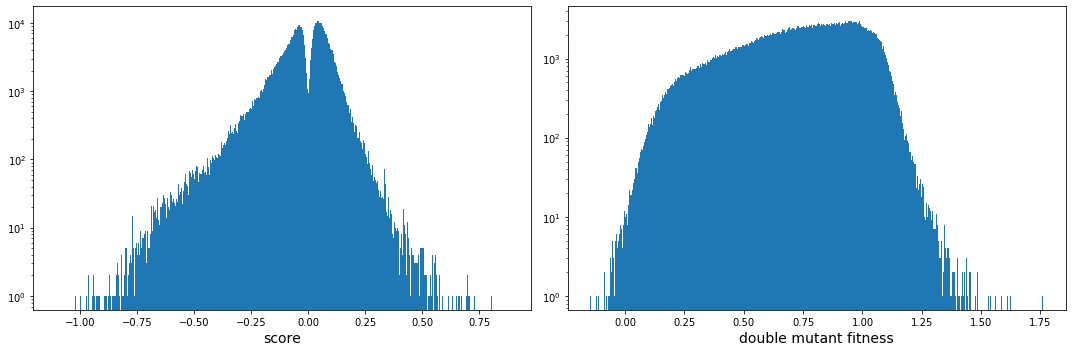

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
for ax, col, xlabel in zip(axes.ravel(),['score',('pair','fit')],['score','double mutant fitness']):
    ax.hist(gint[col],bins = int(np.sqrt(len(gint[col]))));
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

# compute/load PI network metrics

In [21]:
import networkx as nx
pi_graph = nx.from_scipy_sparse_matrix(pi_csc,create_using=nx.Graph)

def in_same_community(i,j,communities):
    return np.any([set([i,j]).issubset(comm) for comm in communities]).astype(np.int)

def calc_inv_dist_mat(shortest_mat):
    inv_dist_mat = 1./shortest_mat
    inv_dist_mat[shortest_mat == 0] = 0
    return inv_dist_mat

## Compute single protein metrics

### Closeness

In [80]:
%%time
closeness = dict_to_np(nx.closeness_centrality(pi_graph))

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


### Degree

In [81]:
%%time
degree = np.array(pi_csc.sum(axis=1)).ravel()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 486 µs


### Eigenvector centrality

In [82]:
%%time
eigs, vecs = slin.eigsh(pi_csc.astype(np.float),k=1)
pfeig, pfvec = eigs[0], vecs[:,0]
#clean up pfvec
pfvec[np.isclose(pfvec,0)] = 0

#make entries positive
pfvec = pfvec/np.sign(pfvec.sum())
assert(not np.any(pfvec < 0)) #assert non-negativity of pfvec

print(np.count_nonzero(np.isclose(pfvec,0)),'are zero')

pfvec_normed = pfvec/np.sum(pfvec)
min_log = np.min(np.log10(pfvec_normed[pfvec>0]))
log_pfvec = np.log10(np.maximum(10**(min_log-1),pfvec_normed))

88 are zero
CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 9.16 ms


### Betweenness centrality

In [83]:
betweenness = dict_to_np(nx.betweenness_centrality(pi_graph))

## Compute protein pair metrics

### Community identity

In [84]:
%%time
communities = nx.community.greedy_modularity_communities(pi_graph)

CPU times: user 7.84 s, sys: 4 ms, total: 7.84 s
Wall time: 7.84 s


### Shortest paths

Find the shortest path between each protein pair

In [86]:
%%time
shortest_iter = nx.shortest_path_length(pi_graph)
shortest_mat_lt = np.full([n_genes,n_genes],0)
for source, targets in shortest_iter:
    for target, dist in targets.items():
        if target < source:
            shortest_mat_lt[source,target] = dist
shortest_mat = shortest_mat_lt + shortest_mat_lt.T #symmetrize
shortest_mat = sparse.csc_matrix(shortest_mat)

inv_dist_mat = 1./shortest_mat
inv_dist_mat[shortest_mat == 0] = 0 #For the diagonals

CPU times: user 1min 50s, sys: 84 ms, total: 1min 50s
Wall time: 1min 50s


### Number of common neighbors

In [94]:
%%time
def n_neighbors(pi_graph,i,j):
    return len(list(nx.common_neighbors(pi_graph,i,j)))
neighbor_pairs, ilist, jlist = list(zip(*[
    (n_neighbors(pi_graph,i,j),i,j)
    for i,j in itertools.product(range(n_genes),range(n_genes))
    if i < j]))
#create symmetric matrix
neighbor_mat_csc = sparse.csc_matrix(sparse.coo_matrix(
        (neighbor_pairs + neighbor_pairs,(ilist + jlist,jlist + ilist))
))

CPU times: user 1min 16s, sys: 716 ms, total: 1min 17s
Wall time: 1min 17s


## save network metrics

In [100]:
cache_dir = 'cached/yeast/032920/dontoverwrite'
filenames = 'closeness,degree,logeigcent,between,communities,shortest,sharedneighbors'.split(',')
network_data = [closeness,degree,log_pfvec,betweenness,communities,shortest_mat.astype(np.uint8),neighbor_mat_csc]
try:
    for name, arr in zip(filenames,network_data):
        if name == 'sharedneighbors':
            sparse.save_npz(cache_dir + name + '.npz',arr)
        else:
            np.save(cache_dir + name + '.npy',arr)
    print('saved')
except:
    raise

saved


## load network metrics

In [22]:
cache_dir = 'cached/yeast/032920/'
filenames = 'closeness,degree,logeigcent,between,communities,shortest,sharedneighbors'.split(',')
try:
    network_data = [sparse.load_npz(cache_dir + name + '.npz') if name == 'sharedneighbors'
    else np.load(cache_dir + name + '.npy',allow_pickle=True)
    for name in filenames]
    print('loaded')
    closeness,degree,log_pfvec,betweenness,communities,shortest_mat,neighbor_mat_csc = network_data
except:
    raise

loaded


## Network metric histograms

### Single vertex

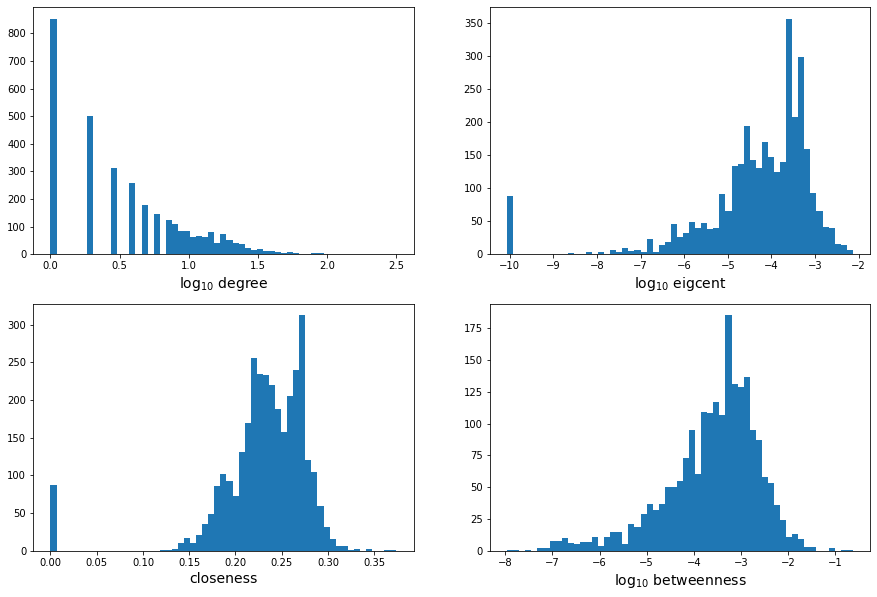

In [135]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
for ax, prop, name in zip(axes.ravel(),
                          [np.log10(degree),log_pfvec,closeness,np.log10(betweenness[~np.isclose(betweenness,0)])],
                          r'$\log_{10}$ degree,$\log_{10}$ eigcent,closeness,$\log_{10}$ betweenness'.split(',')):
        
    ax.hist(prop,bins=int(np.sqrt(n_genes)))
    ax.set_xlabel(name,fontsize=14)

    if name == 'eigcent':
        ax.axvline(np.log10(1/n_genes),c='black')

#plt.hist(np.log10(pfvec_normed[pfvec>0]),bins=int(np.sqrt(n_genes)));
#plt.hist(log_pfvec,bins=int(np.sqrt(n_genes)));

#plt.title('nonzero pfvec_normed_i')
#plt.xlabel('log pfvec_normed_i')
plt.show()

### Vertex pairs

In [154]:
import sklearn.cluster as cluster
spectral_model = cluster.SpectralBiclustering(n_clusters=100)
spectral_model.fit(pi_csc)

def spectral_sort(mat):
    mat = mat.copy()[np.argsort(spectral_model.row_labels_)]
    mat = mat[:, np.argsort(spectral_model.row_labels_)]
    return mat

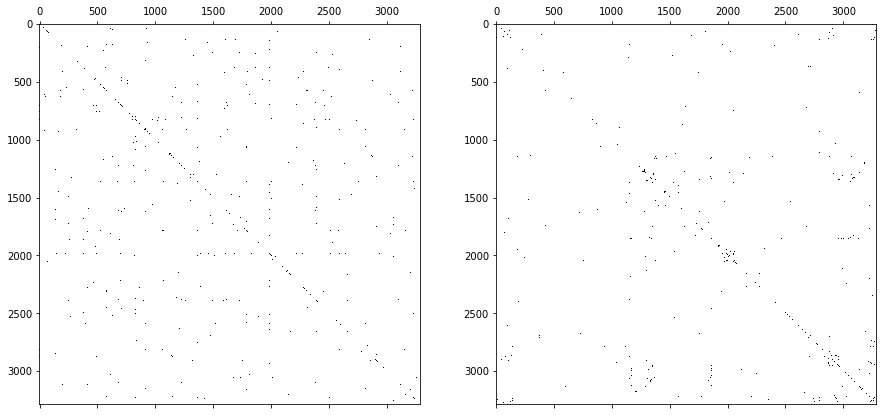

In [151]:
# pi_fit = pi_csc[np.argsort(spectral_model.row_labels_)]
# pi_fit = pi_fit[:, np.argsort(spectral_model.row_labels_)]

fig, axes = plt.subplots(1,2,figsize=(15,7))
for ax, mat in zip(axes,[pi_csc,spectral_sort(pi_csc)]):
    ax.matshow(mat.toarray(), cmap='binary')

/home/akuczala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


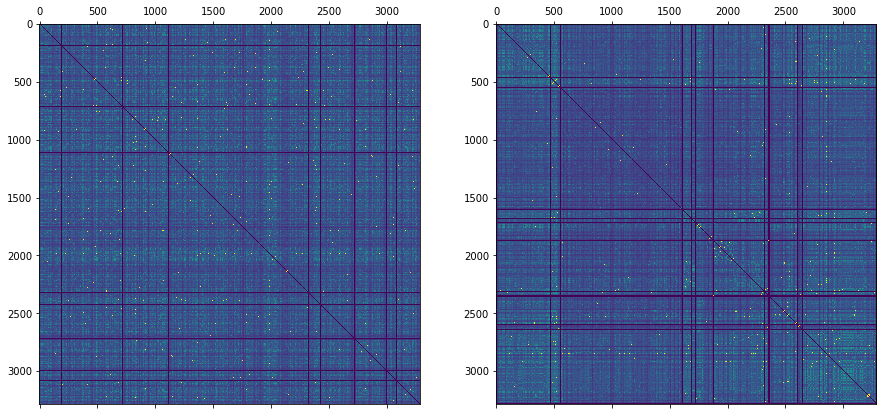

In [156]:
inv_dist_mat = calc_inv_dist_mat(shortest_mat)
fig, axes = plt.subplots(1,2,figsize=(15,7))
for ax, mat in zip(axes,[inv_dist_mat,spectral_sort(inv_dist_mat)]):
    ax.matshow(mat)

In [ ]:
plt.imshow(shortest_mat); plt.colorbar(); plt.show()

plt.imshow(inv_dist_mat); plt.colorbar(); plt.show()

In [169]:
test = neighbor_mat_csc.toarray()
test[test == np.nan ] = 0
spectral_model = cluster.SpectralBiclustering(n_clusters=80)
spectral_model.fit(test)

/home/akuczala/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_bicluster.py:35: RuntimeWarning: divide by zero encountered in true_divide
  row_diag = np.asarray(1.0 / np.sqrt(X.sum(axis=1))).squeeze()
/home/akuczala/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_bicluster.py:36: RuntimeWarning: divide by zero encountered in true_divide
  col_diag = np.asarray(1.0 / np.sqrt(X.sum(axis=0))).squeeze()
/home/akuczala/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_bicluster.py:45: RuntimeWarning: invalid value encountered in multiply
  an = row_diag[:, np.newaxis] * X * col_diag


ValueError: array must not contain infs or NaNs

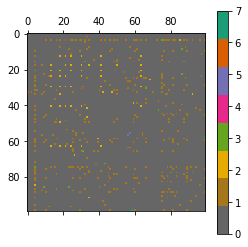

In [168]:
plt.matshow(neighbor_mat_csc.toarray()[:100,:100],cmap='Dark2_r'); plt.colorbar()

# make samples, labels

Paladugu excludes proteins localized to mitochondria

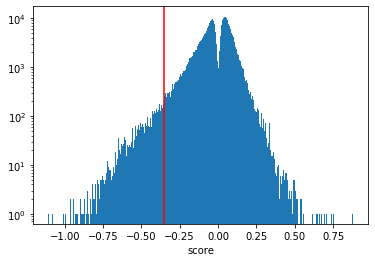

left of threshold: 10432
right of threshhold: 832068


In [41]:
class_sign = -1
label_thresh = -0.35 #lethal threshold chosen by costanzo
#label_thresh = 0 #label positive and negative interactions
plt.hist(gint['score'],bins = int(np.sqrt(len(gint))));
plt.axvline(label_thresh,c='red')
plt.xlabel('score');
plt.yscale('log');  plt.show()
print("left of threshold:", np.count_nonzero(gint['score']<label_thresh))
print("right of threshhold:", np.count_nonzero(gint['score']>label_thresh))


Generate samples: both features and labels

In [42]:
maxmin = True
pair_names = ['max','min'] if maxmin else ['a','b']

vertex_features = 'deg,eigcent,closeness,betweenness'.split(',')
vertex_data = [np.log10(degree),log_pfvec,closeness,betweenness]

pair_features = 'invdist,shareneigh,samecomm'.split(',')
inv_dist_mat = calc_inv_dist_mat(shortest_mat)
pair_funs = [
    lambda i,j: inv_dist_mat[i,j],
    lambda i,j: neighbor_mat_csc[i,j],
    lambda i,j: in_same_community(i,j,communities)
]
features = list(itertools.product(pair_names,vertex_features)) + list(itertools.product(['pair'],pair_features))
samples = gint.copy()

samples['label'] = samples['score']*class_sign>label_thresh*class_sign

#map vertex features to samples
for vfeat, vdat in zip(vertex_features,vertex_data):
    a_samples, b_samples = vdat[samples.a.i], vdat[samples.b.i]
    if maxmin:
        samples['max',vfeat] = np.maximum(a_samples,b_samples)
        samples['min',vfeat] = np.minimum(a_samples,b_samples)
    else:
        samples['a',vfeat] = a_samples
        samples['b',vfeat] = b_samples

#map vertex pair features
for pfeat, pfun in zip(pair_features,pair_funs):
    samples['pair',pfeat] = np.vectorize(pfun)(samples.a.i,samples.b.i)


/home/akuczala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


## Scale features

In [217]:
for feature, scaled in zip(features,sklearn.preprocessing.scale(samples[features]).T):
    samples[feature[0],feature[1]] = scaled

## Feature variance

Text(0.5, 1.0, 'PC 0')

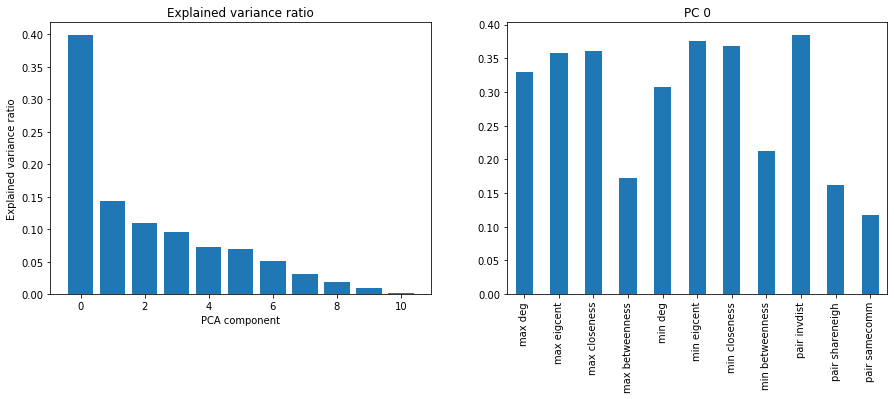

In [69]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(sklearn.preprocessing.scale(samples[features]))

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.ravel()
axes[0].bar(np.arange(len(features)),pca.explained_variance_ratio_);
axes[0].set_xlabel('PCA component'); axes[0].set_ylabel('Explained variance ratio')
axes[0].set_title('Explained variance ratio')
pd.Series(pca.components_[0],index=list(map(' '.join,features))).plot.bar(ax=axes[1])
axes[1].set_title('PC 0')
# pd.Series(pca.components_[1],index=list(map(' '.join,features))).plot.bar(ax=axes[2])
# axes[1].set_title('PC 1')
# pd.Series(pca.components_[2],index=list(map(' '.join,features))).plot.bar(ax=axes[3])
# axes[1].set_title('PC 2')
# plt.show()

## Take sample subset

In [44]:
def sample_balanced(samples,frac):
    smallest = min(len(samples[samples.label == 0]),len(samples[samples.label == 1]))
    samples0 = samples[samples.label == 0].sample(n=int(smallest*frac))
    samples1 = samples[samples.label == 1].sample(n=int(smallest*frac))
    return samples0.append(samples1,verify_integrity = True).sample(frac=1)
def sample_between(samples,score_low,score_high, **kwargs):
    return samples[(samples['score'] > score_low) & (samples['score'] < score_high)].sample(**kwargs)
def sample_outside(samples,score_low,score_high, **kwargs):
    return samples[(samples['score'] < score_low) | (samples['score'] > score_high)].sample(**kwargs)

In [73]:
sample_subset = sample_balanced(samples,frac=1)

#divide into training, testing
frac_test = 0.2 # 1/5
n_test = int(len(sample_subset)*frac_test)
n_train = len(sample_subset) - n_test

train_samples = sample_subset.iloc[:n_train]
test_samples = sample_subset.iloc[n_train:]

nlabel0 = len(sample_subset[sample_subset.label==0])
nlabel1 = len(sample_subset[sample_subset.label==1])

display(sample_subset)
print('number of small samples:',len(sample_subset),'/',len(samples))
print('fraction of labels=1: ','%0.3f' % (nlabel1/(nlabel0 + nlabel1)))

a     b        a        b     score         a         b      pair  \
            i     i     name     name                 fit       fit       fit   
1001067   762  2347  YDR473C  YMR033W -0.075600  0.899400  0.922700  0.754300   
49548      38   891  YAL059W  YER107C -0.407400  0.679000  1.035500  0.295700   
176087    128  3088  YBR020W  YPL106C  0.089500  0.992500  0.456000  0.542100   
1436662  1208  2481  YGR089W  YMR268C  0.056800  0.887800  0.993300  0.938700   
445474    315  2055  YCR002C  YLR100W -0.523000  0.717300  0.929100  0.143450   
...       ...   ...      ...      ...       ...       ...       ...       ...   
1079652   841  3215  YER022W  YPR070W -0.484700       NaN  0.705300  0.220600   
1838632  1714  2905  YJR043C  YOR144C -0.606150  0.908600  0.908600  0.215350   
731029    534  1522  YDR071C  YIL112W -0.078800  0.960000  0.978800  0.860900   
585301    421  1440  YDL105W  YHR171W  0.021275  0.823175  0.823175  0.684975   
1448820  1221  2376  YGR113W  YMR076C -0.457100  0.922000  0.727000  0.213200   

         label       max       min       max       min       max       min  \
                     deg       deg   eigcent   eigcent closeness closeness   
1001067  False  1.204120  1.000000 -3.144887 -3.575499  0.254811  0.245163   
49548     True  0.477121  0.301030 -3.759410 -4.623114  0.247895  0.211526   
176087   False  0.903090  0.698970 -3.041364 -3.773303  0.298391  0.241775   
1436662  False  1.079181  0.903090 -3.736509 -3.764182  0.248508  0.244547   
445474    True  1.113943  0.602060 -3.304153 -4.938155  0.277320  0.210341   
...        ...       ...       ...       ...       ...       ...       ...   
1079652   True  1.505150  1.146128 -2.593067 -2.913288  0.277939  0.254499   
1838632   True  0.845098  0.778151 -3.544190 -3.890706  0.265386  0.245201   
731029   False  0.954243  0.000000 -3.328705 -3.599270  0.268961  0.263344   
585301   False  0.778151  0.301030 -4.706415 -5.880414  0.218012  0.182027   
1448820   True  1.301030  0.477121 -3.449290 -3.954329  0.273328  0.249924   

                max         min      pair                      
        betweenness betweenness   invdist shareneigh samecomm  
1001067    0.000489    0.000067  0.250000          0        0  
49548      0.000308    0.000000  0.250000          0        0  
176087     0.000239    0.000077  0.250000          0        0  
1436662    0.001380    0.000000  0.250000          0        0  
445474     0.002704    0.000503  0.250000          0        0  
...             ...         ...       ...        ...      ...  
1079652    0.000886    0.000028  1.000000          9        1  
1838632    0.000788    0.000290  0.500000          1        1  
731029     0.001391    0.000000  0.333333          0        0  
585301     0.002407    0.000015  0.166667          0        0  
1448820    0.001529    0.000161  0.333333          0        0  

[20864 rows x 20 columns]

number of small samples: 20864 / 842503
fraction of labels=1:  0.500


# fit data

## define helper functions

In [132]:
import sklearn.metrics as metrics
from sklearn.inspection import permutation_importance

def train(model,train_samples,features,labels='label'):
    model.fit(train_samples[features],train_samples[labels])

def predict(model,test_samples,features):
    return model.predict(test_samples[features])

def cross_validate(model,samples,features,labels='label',cv=5,scoring = None,verbose=True):
    if scoring is None:
        scoring = ['accuracy_score']
    scores = sklearn.model_selection.cross_validate(
        model, samples[features], samples[labels],
        cv=cv,scoring = scoring)
    for score_name in scoring:
        print(score_name + ": %0.2f (+/- %0.2f)" % (
            scores['test_' + score_name].mean(), scores['test_' + score_name].std() * 2))
    return scores

def calc_matt_coef(model,test_samples,features,labels='label'):
    return metrics.matthews_corrcoef(test_samples[labels],model.predict(test_samples[features]))

def plot_pr_curve(model,test_samples,features,labels='label',ax = None,**kwargs):
    metrics.plot_precision_recall_curve(model,test_samples[features],test_samples[labels],ax = ax,**kwargs)
    #ax.set_aspect(aspect=0.5)
def plot_roc_curve(model,test_samples,features,labels='label',ax=None,**kwargs):

    metrics.plot_roc_curve(model,test_samples[features],test_samples[labels],ax=ax,**kwargs)
    ax.plot([0,1],[0,1],c='gray',linestyle='--')
    ax.set_aspect(1)
    
def plot_confusion_matrix(model,samples,features,labels='label',**kwargs):
    return metrics.plot_confusion_matrix(model,samples[features],samples[labels],
                                         cmap='Blues',**kwargs)

In [125]:
def calc_importance(model,samples,features,labels='label',n_repeats=10,n_jobs=8):
    importance_dict = permutation_importance(
        model,samples[features],samples[labels])
    return importance_dict

def plot_importances_ab(features,importances,axes = None):
    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=(18,6))
    
    #convert importance matrix to dataframe
    imdf = pd.DataFrame(importances['importances'].T,
                        columns = pd.MultiIndex.from_tuples(features))
    #combine features from a, b or max, min
    imdf_ab = imdf.stack(level=0)
    
    #compute importance statistics
    imdf_stats = \
         imdf \
        .agg([np.mean,np.std]) \
        .transpose() \
        .sort_values('mean',axis=0,ascending=False)
    #display(imdf_stats)

    #errorbar plot of feature importance
    imdf_stats.plot(y='mean',ax=axes[0])
    axes[0].errorbar(np.arange(len(imdf_stats)),imdf_stats['mean'],
                 yerr=imdf_stats['std'],linestyle='',capsize=10,marker='o')
    axes[0].set_ylabel('importance')
    
    #box plot of feature importance
    imdf_ab.reindex(imdf_ab.mean().sort_values(ascending=False).index, axis=1).boxplot(ax=axes[1])
    
def plot_importances(features,importances,pair_names,sort = False,ax=None):
    if pair_names == ['a','b']:
        plot_importances_ab(features,importances,axes=ax)
        return
    #print(sort)
    #convert importance matrix to dataframe
    imdf = pd.DataFrame(importances['importances'].T,
                        columns = pd.MultiIndex.from_tuples(features))
    index = imdf.mean().sort_values(ascending=False).index if sort else imdf.columns
    #print(features)
    #print(index)
    #box plot of feature importance
    imdf.reindex(index, axis=1).boxplot(ax = ax)
    ticklabels = [t[0]+'\n' + t[1][:min(len(t[1]),4)] for t in index]
    ax.set_xticklabels(ticklabels)
    #compare max, min of each vertex feature
#     for name,color in zip(pair_names,['r','b']):
#         imdf[name].boxplot(ax=axes[1],color=color)

#compute partial dependence on the two features with the highest mean importance
def plot_top_dependences(model,samples,features,importances,ax = None):
    #format feature names into strings
    feature_names = np.array(list(map(' '.join,features)))
    major_features = tuple(feature_names[np.argsort(importances['importances_mean'])[::-1]][:2])
    sklearn.inspection.plot_partial_dependence(
    model,samples[features],[major_features],
        feature_names = feature_names, ax = ax, contour_kw = dict(cmap = 'Blues'))

## Benchmarking functions

In [71]:
def benchmark(model,train_samples,test_samples,features,labels='label',scoring=None):
    print('Cross validation')
    cross_validate(model,train_samples,features,labels,scoring = scoring)
    print('Training')
    train(model,train_samples,features,labels)
    print('Testing')
    test_results = predict(model,test_samples,features)
    print('Calculating importances')
    importances = calc_importance(model,test_samples,features,labels)
    
    return dict(
        model=model, test_samples=test_samples, features = features,
        test_results=test_results, importances=importances)
    
def benchmark_plots(model,test_samples,test_results,importances,features,labels='label',axes = None):
    #plot performance metrics
    if axes is None:
        fig, axes = plt.subplots(2,2,figsize=(15,15))
        axes = axes.ravel()
    plot_confusion_matrix(model,test_samples,features,labels,ax = axes[0])
    plot_roc_curve(model,test_samples,features,labels,ax = axes[1])
    plot_pr_curve(model,test_samples,features,labels,ax = axes[2])
    
    plot_importances(features,importances,pair_names,ax =axes[3])
    plot_top_dependences(model,test_samples,features,importances,ax = axes[4])
    

## Binary classification

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [138]:
model_names = ['Logistic','Random Forest','MLP']
models = [
    LogisticRegression(max_iter=500,n_jobs=8),
    RandomForestClassifier(n_jobs=8),
    MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=500)]

results = []
for model, model_name in zip(models,model_names):
    display_markdown(Markdown('Benchmarking ' + model_name))
    t0 = time.time()
    result = benchmark(model,train_samples,test_samples,features,
                       scoring = ['roc_auc','average_precision'])
    results.append(result)
    print('time:',int(time.time()-t0),'s')
plt.show()

Benchmarking Logistic

Cross validation
roc_auc: 0.66 (+/- 0.01)
average_precision: 0.70 (+/- 0.01)
Training
Testing
Calculating importances
time: 5 s


Benchmarking Random Forest

Cross validation
roc_auc: 0.73 (+/- 0.01)
average_precision: 0.75 (+/- 0.02)
Training
Testing
Calculating importances
time: 9 s


Benchmarking MLP

Cross validation
roc_auc: 0.67 (+/- 0.01)
average_precision: 0.71 (+/- 0.01)
Training
Testing
Calculating importances
time: 35 s


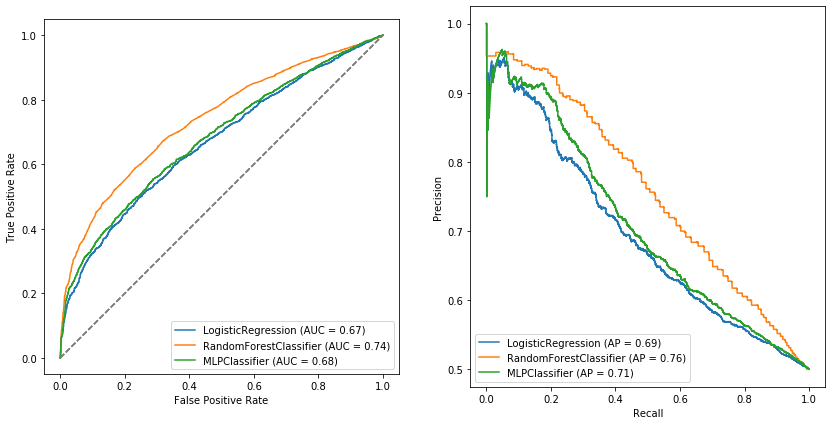

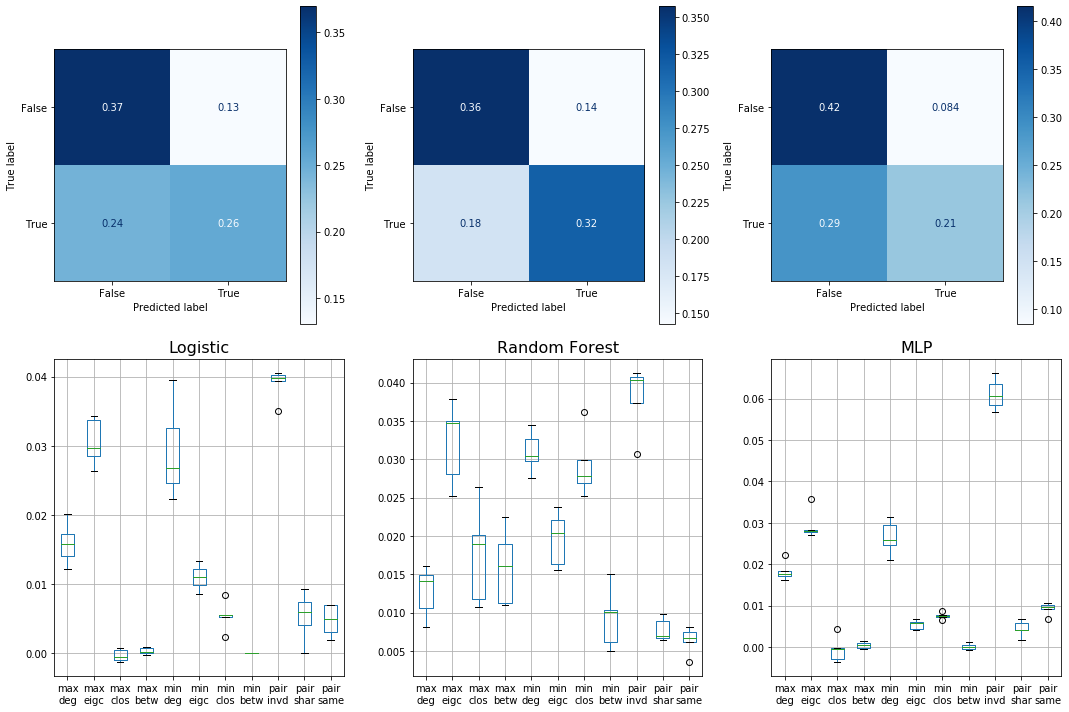

In [139]:
fig0, axes0 = plt.subplots(1,2,figsize = (14,7))
fig1, axes1 = plt.subplots(2,3,figsize = (15,10))

for model_name, result, axes in zip(model_names,results,axes1.T):
    plot_roc_curve(result['model'],result['test_samples'],features,'label',ax = axes0[0])
    plot_pr_curve(result['model'],result['test_samples'],features,'label',ax = axes0[1])
    
    plot_confusion_matrix(result['model'],result['test_samples'],features,'label',ax = axes[0],normalize='all')
    plot_importances(features,result['importances'],pair_names,ax = axes[1])
    axes[1].set_title(model_name,fontsize=16)
plt.tight_layout()
plt.show(fig0)
plt.show(fig1)

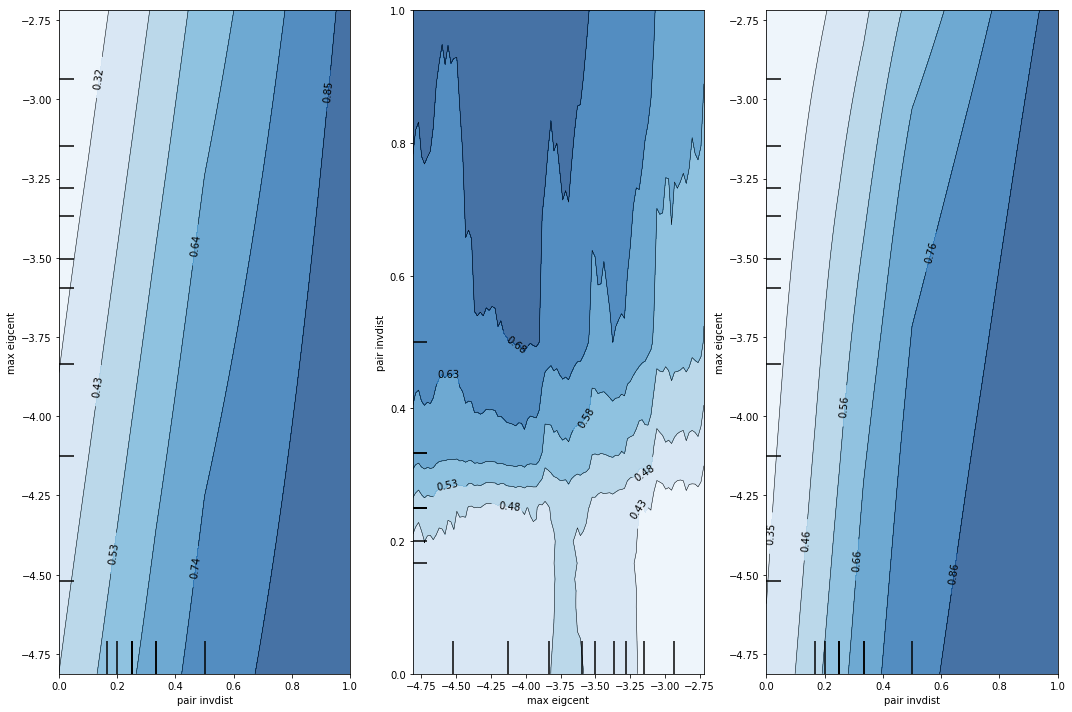

In [137]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

for model_name, result, ax in zip(model_names,results,axes):
    
    plot_top_dependences(result['model'],result['test_samples'],features,result['importances'],ax=ax)
    ax.set_title(model_name,fontsize=16)
plt.tight_layout()
plt.show()

## Regression models

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#from sklearn.svm import SVR #too slow

In [35]:
models = [LinearRegression(n_jobs = 8),RandomForestRegressor(n_jobs=8)]
model_names = ['Linear','Random Forest']
results = []
for model, model_name in list(zip(models,model_names)):
    display_markdown(Markdown('Benchmarking ' + model_name))
    t0 = time.time()
    result = benchmark(model,samples,small_training,small_testing,[features],labels='score')
    results.append(result)
    print(int(time.time()-t0))
    #benchmark_plots(axes = plot_axes,**result)

Benchmarking Linear

Cross validation
Accuracy: 0.00 (+/- 0.00)
Training
Testing
Calculating importances
0


Benchmarking Random Forest

Cross validation
Accuracy: 0.00 (+/- 0.00)
Training
Testing
Calculating importances
18


AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

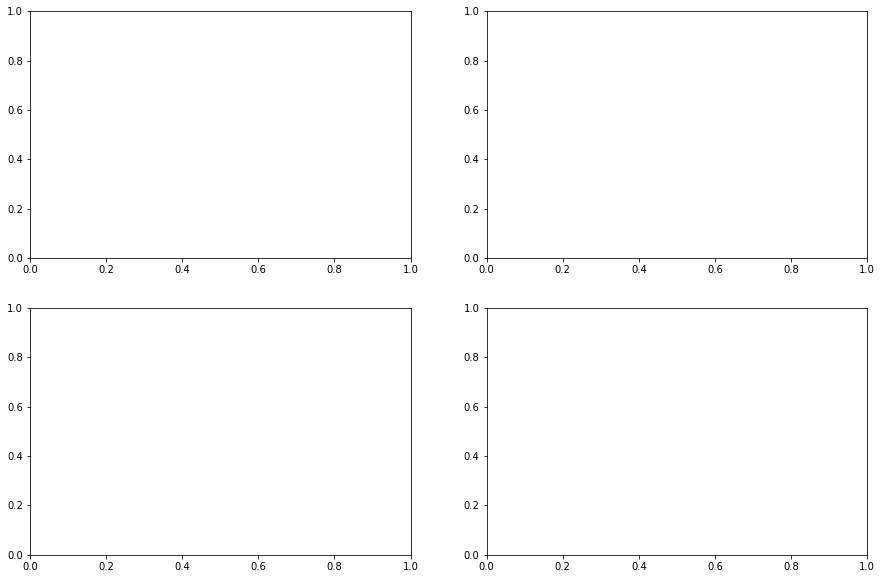

In [27]:
fig, axes = plt.subplots(2,2,figsize = (15,10))
for model, result, plot_axes in zip(models,results,axes.T):
    plot_importances(features,result['importances'],pair_names,ax =axes[0])
    plot_top_dependences(model,result['test_samples'],features,result['importances'],ax = axes[1])
plt.show()

In [29]:
metrics.explained_variance_score(result['test_samples']['score'],result['test_results'])

-0.00809404897791599

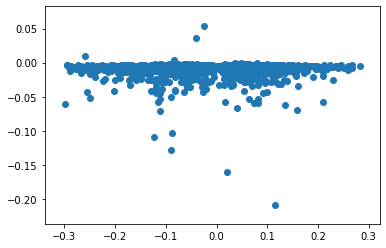

In [28]:
plt.scatter(result['test_samples']['score'],result['test_results'])